In [49]:
import pandas as pd
import numpy as np
import seaborn as sbn
import re
from matplotlib import pyplot


# Load the CSV and Name the Columns (I wasn't sure what a few of these were so I just dropped 'em')

In [175]:
df = pd.read_csv('./assets/salaries.csv', names=['date','tmp0','title','tmp','tmp2','location','tmp23','tmp3','tmp34','tmp4','org_size','org_size_bucket','salary','tmp5','tmp6','experience', 'tmp7','tmp8','industry','tmp9', 'comments', 'tmp10'])
df[['title','location','salary','experience']]

,title,location,salary,experience
0,Head of <redacted> technologies,"St. Paul, Minnesota","US$165,000",NaN
1,Senior Software Engineer,Porto Alegre/RS - Brazil,US$ 18400 / year,17
2,Senior Site Reliability Engineer,Toronto,"CAD $174,000",21
3,Software Engineer,"Chantilly, VA","$98,000.00",NaN
4,Web Developer,"Canberra, ACT","$97,294.00",13
...,...,...,...,...
1075,System Engineer,"Los Angeles, CA","$82,500.00",4
1076,Senior Javascript Developer,"Saratoga Springs, UT","$122,109.00",10
1077,Associate consultant - data scientist,Washington d.c.,"$95,000.00",1
1078,Senior full stack engineer,"Ann Arbor, MI","$95,000.00",10


In [176]:
# Turn 100k into 100,000 and remove commas
cleaned_salary = df['salary'].str.replace('k','000').str.replace(',','')
# extract a number from the salaries if possible. Still won't work if people wrote like "one hundred thousand" 
# I guess that might be one change you could make to the survey is specify this field is in dollars and only allow a numeric input?
cleaned_salary = cleaned_salary.str.extract('(\d+)', expand=False)
cleaned_salary = cleaned_salary.astype(float)

# extract a numeric from the experience answer too if possible
cleaned_experience = df['experience'].str.extract('(\d+)').astype(float)

df['salary'] = cleaned_salary
df['experience'] = cleaned_experience


# Take the first pre-comma chunk of text for location (so "Los Angeles, CA" and "Los Angeles" bot become "Los Angeles")
df['location'] = df['location'].str.split(',').str[0]
# Remove non-alpha characters and lowercase to try and make these location names more standard
df['location'] = df['location'].fillna('').apply(lambda x: re.sub("[^a-zA-Z ]+", '', x, flags=re.UNICODE)).str.lower()
# Just fix DC manually
df.loc[df['location'] == 'washington', 'location'] = 'washington dc'

# A couple salaries seem like weird outliers, I just dropped them

In [165]:
df = df[df['salary'] < 1000000]

In [181]:
# this doesnt cover a lot of these titles, but you get the idea
def title_substrings(title, substrings):
    for substring in substrings:
        if substring in title:
            return True
    return False

def title_function(title):
    title = title.lower()
    if title_substrings(title, ['data', 'artificail', 'ml', 'scien']):
        return 'Data'
    elif title_substrings(title, ['front', 'javascript', 'react', 'ui']):
        return 'Front End'
    elif title_substrings(title, ['back']):
        return 'Back End'
    elif title_substrings(title, ['full','web', 'rails']):
        return 'Full Stack'
    elif title_substrings(title, ['mobile','ios', 'android']):
        return 'Mobile'
    elif title_substrings(title, ['ops','system', 'security', 'tool', 'network']):
        return 'Ops and Security'
    elif title_substrings(title, ['ux','user', 'design']):
        return 'UX and Design'
    elif title_substrings(title, ['manag','director', 'arch', 'president', 'cto', 'ceo', 'head', 'gm', 'coo', 'vp', 'chief']):
        return 'Management and Leadership'
    elif title_substrings(title, ['market', 'content', 'writ']):
        return 'Marketing and Content'
    elif title_substrings(title, ['test', 'quality', 'qa']):
        return 'QA and Testing'
    elif title_substrings(title, ['support']):
        return 'Support'
    elif title_substrings(title, ['product']):
        return 'Product'
    elif title_substrings(title, ['engineer', 'software', 'dev', 'program', 'tech']):
        return 'General Engineering'
    else:
        return 'Unknown'

df['title_categories'] = df['title'].fillna('').apply(title_function)

# I don't know what a lot of these titles are, these are the titles I didn't categorize in any way...

In [182]:
df[df['title_categories'] == 'Unknown']['title'].unique()

array(['Business Analyst', 'SWE Intern', 'Senior Consultant',
       'Community Advocate', 'Applications Analyst', 'Solutions Analyst',
       'Career Success Coach', 'Junior Salesforce Administrator', 'ISSO',
       'Strategy & Operations', 'Lead Analyst', 'Lead SRE',
       'Lead Consultant', 'Advanced Physicist',
       'Sr Business Analyis Consultant', "What's your job title?",
       'Sr. SWE', 'Senior Business Analyst', 'Red Team Lead', 'Associate',
       'cloud trainee', 'Senior SDM', 'Senior Sdet', 'SRE',
       'Jr. Salesforce Administrator', 'Senior FP&A Analyst', 'Staff 1',
       'Senior Digital Strategist', 'ERP Consultant', 'Sales Strategy',
       'Social Media Specialist', 'Sr Analyst', 'Sr SDE', 'Team Lead',
       'Senior Financial Analyst', 'Lead Producer', 'z/os scheduller',
       'Senior SOC Analyst', 'CIO', 'Sr Sales Operations Analyst',
       'Salesforce Consultant', 'Senior SRE',
       'Senior Partnerships Associate', 'Server Storage Administrator',
       '

# Years of Experience Versus Pay (interesting how it levels out more or less after a decade)

<ipython-input-168-ba46ace6ae63>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set(xlabel='Years of Experience', ylabel='Salary', yticklabels=range(0, 1000000, 50000), title='Salary By Years of Experience')
<ipython-input-168-ba46ace6ae63>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


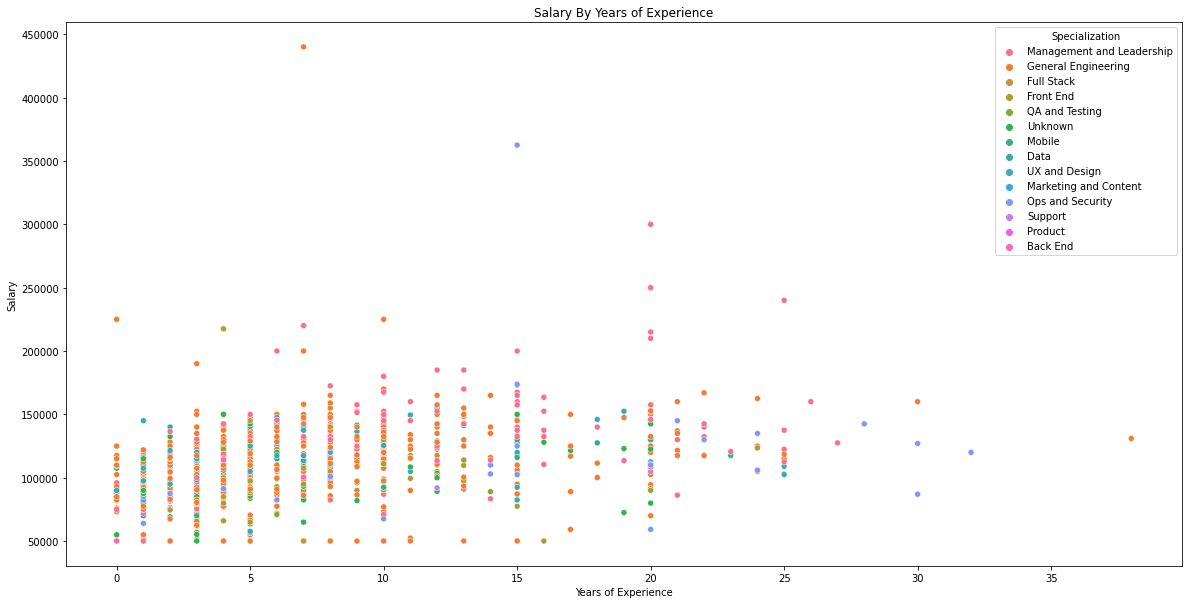

In [168]:

fig, ax = pyplot.subplots(figsize=(20,10))

plot = sbn.scatterplot(data=df, x='experience', y='salary', ax=ax, hue='title_categories')
plot.set(xlabel='Years of Experience', ylabel='Salary', yticklabels=range(0, 1000000, 50000), title='Salary By Years of Experience')
fig.show()
ax.legend(title='Specialization')
fig.savefig('./graphs/experience-scatter.png')

# Distribution of Pay

<ipython-input-177-c4d3367d2089>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


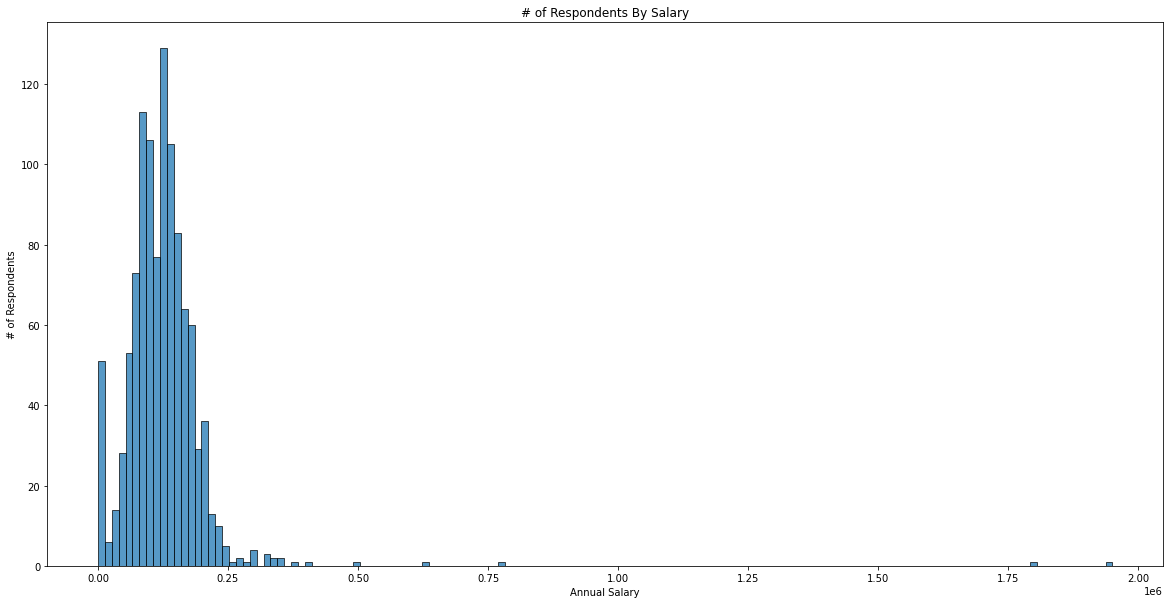

In [177]:

fig, ax = pyplot.subplots(figsize=(20,10))

plot = sbn.histplot(df['salary'], ax=ax)
plot.set(xlabel='Annual Salary', ylabel='# of Respondents', title='# of Respondents By Salary')

fig.show()
fig.savefig('./graphs/pay-histogram.png')

# Pay in Different Cities

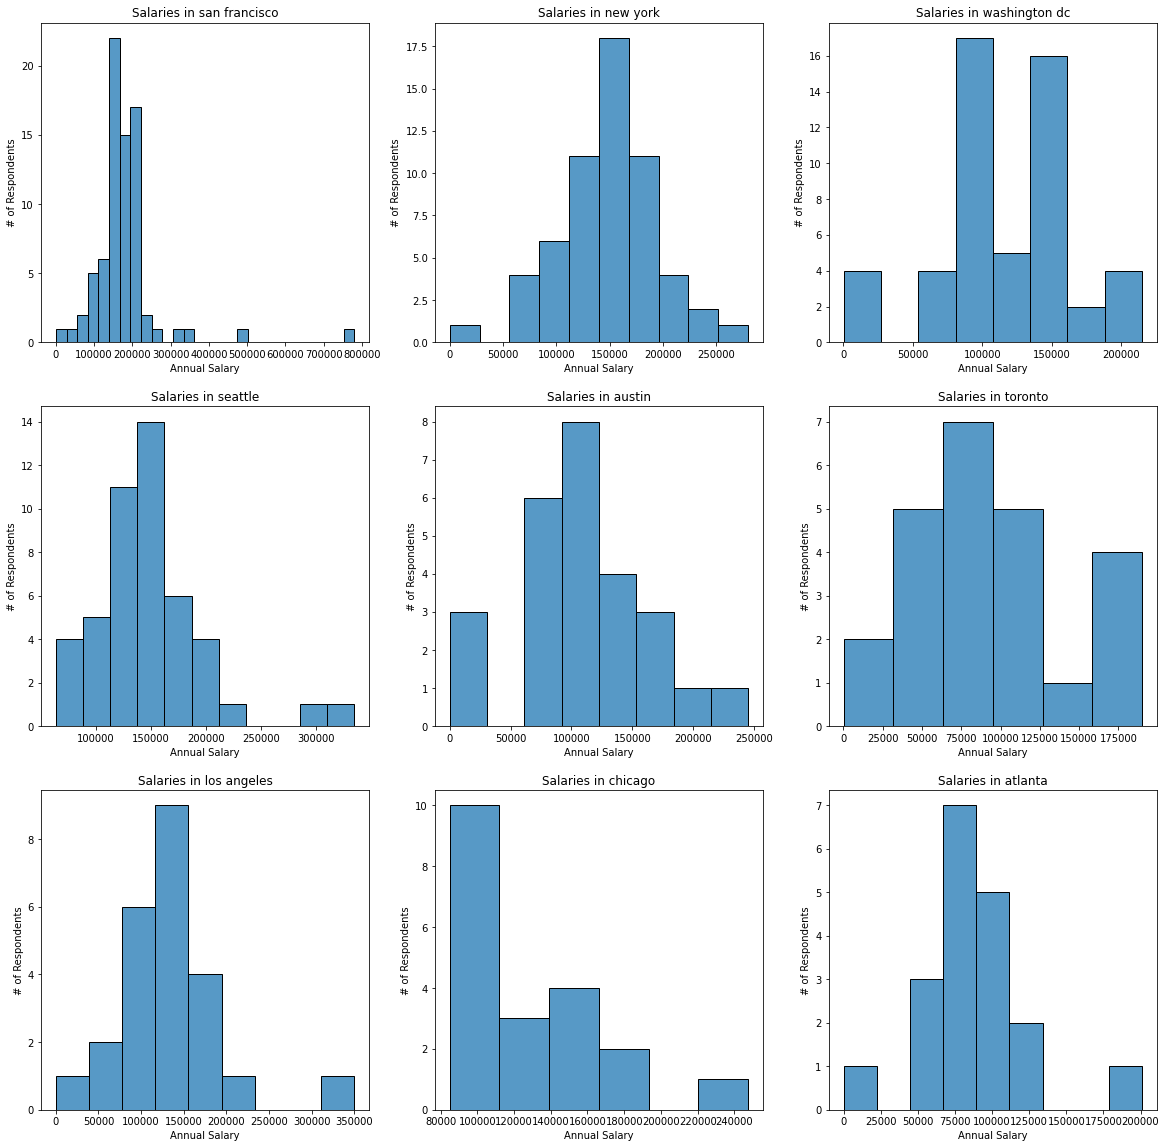

In [213]:
top_cities = df['location'].value_counts()[:9].index

fig, axs = pyplot.subplots(3, 3, figsize=(20,20))
for i, figure in enumerate(axs.flat):
    plot = sbn.histplot(df[df['location'] == top_cities[i]]['salary'], ax=figure)
    plot.set(title=f'Salaries in {top_cities[i]}', xlabel='Annual Salary', ylabel='# of Respondents')
fig.savefig('./graphs/cities-histogram.png')

# Pay Distribution in Different Specialties

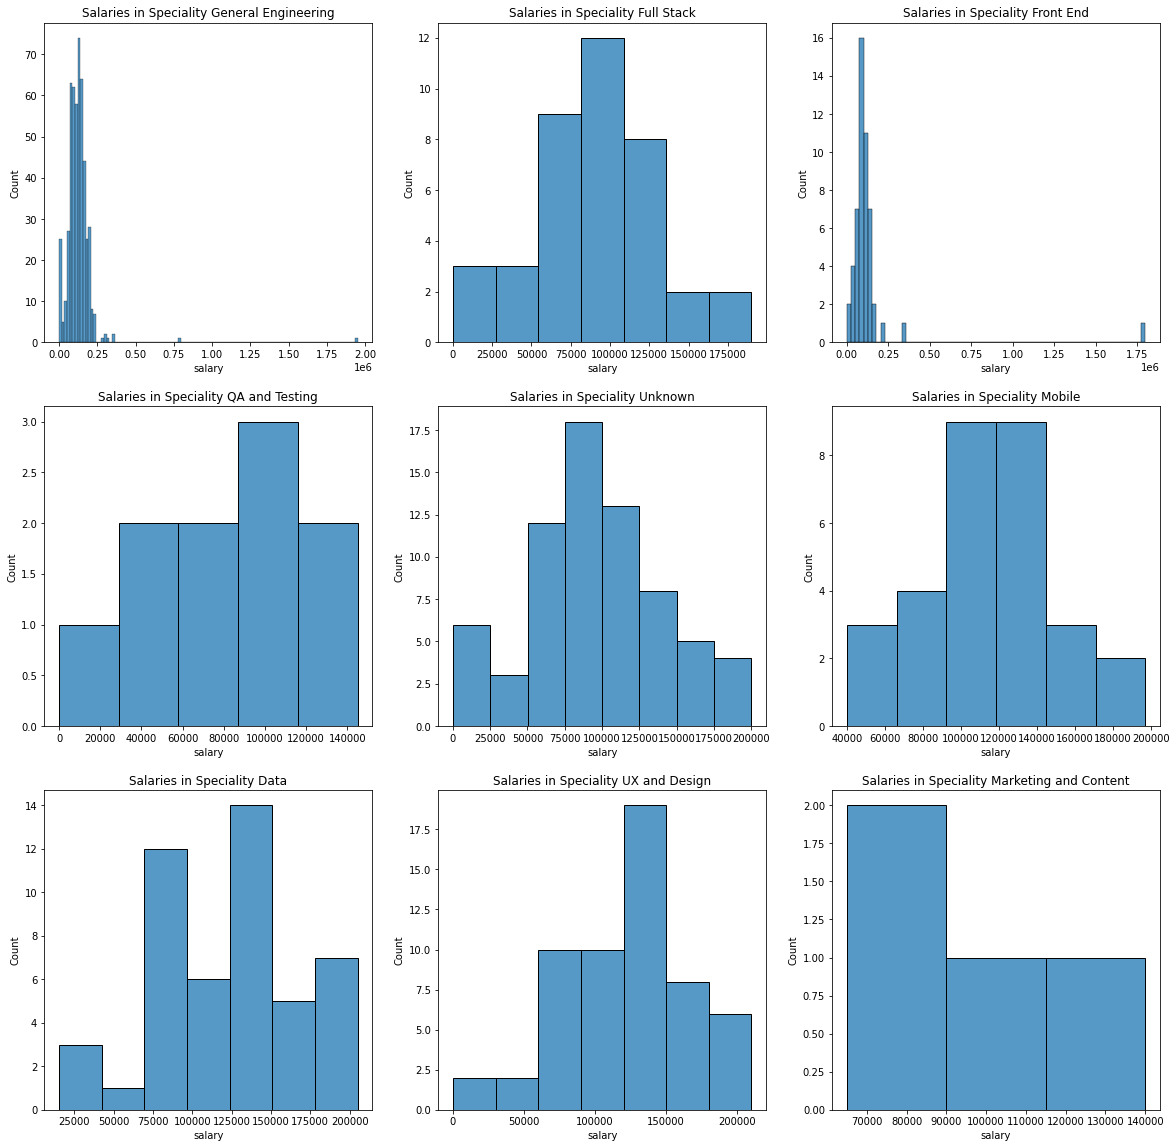

In [214]:
title_categories = df['title_categories'].unique()[1:]

fig, axs = pyplot.subplots(3, 3, figsize=(20,20))
for i, figure in enumerate(axs.flat):
    plot = sbn.histplot(df[df['title_categories'] == title_categories[i]]['salary'], ax=figure)
    plot.set(title=f'Salaries in Speciality {title_categories[i]}')
fig.savefig('./graphs/specialties-histogram.png')

# Respondents from Different Specialties

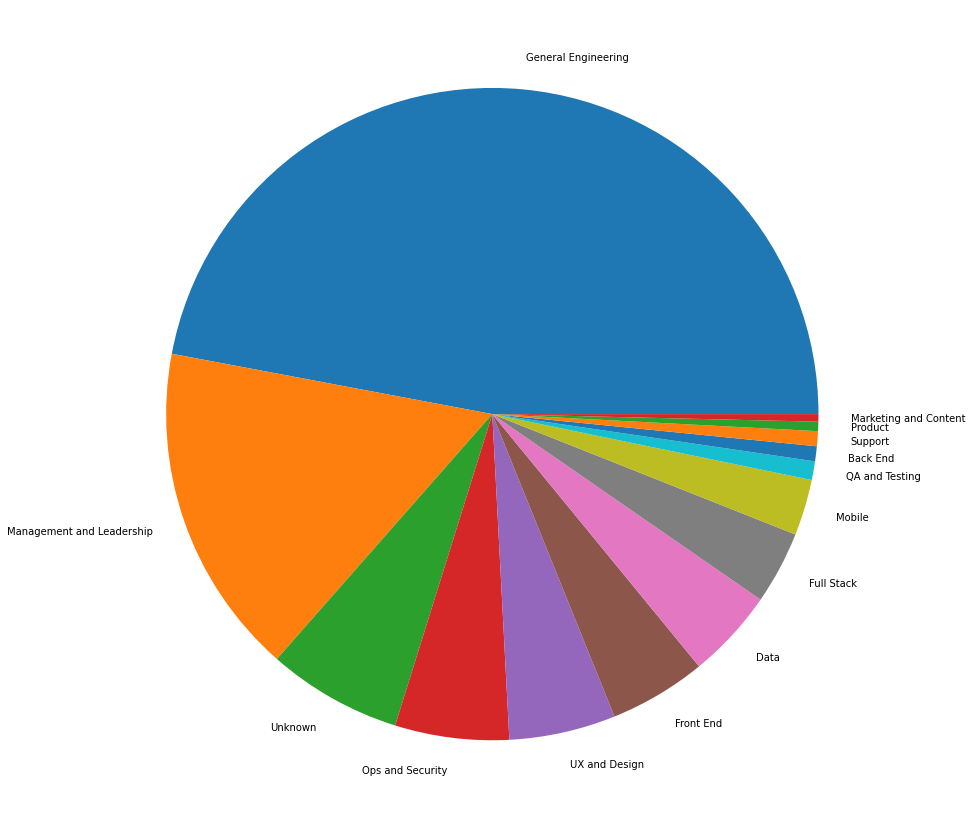

In [216]:
counts = df['title_categories'].value_counts()
fig, axs = pyplot.subplots(figsize=(15,15))

pyplot.pie(counts, labels=counts.keys())
fig.savefig('./graphs/specialty-pie.png')


In [161]:
df.to_csv('./assets/updated_salaries.csv')

In [190]:
df['title_categories']

0       Management and Leadership
1             General Engineering
2             General Engineering
3             General Engineering
4                      Full Stack
                  ...            
1075             Ops and Security
1076                    Front End
1077                         Data
1078                   Full Stack
1079                      Unknown
Name: title_categories, Length: 1080, dtype: object